In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

In [2]:
# load calibration parameters
params_pkl = pickle.load(open('coeffs.p', 'rb'))
mtx = params_pkl['mtx']
dist = params_pkl['dist']

In [3]:
# define a helper function for displaying images
def show_img(img, cmap=None):
    cols = 2
    rows = (len(img)+1)//cols
    plt.figure(figsize=(14, 16))
    for i, image in enumerate(img):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image, cmap=cmap)
    plt.show()

In [4]:
# load test images
test_imgs = []
for img in glob.glob('./test_images/all/*.jpg'):
    image = mpimg.imread(img)
    test_imgs.append(image)

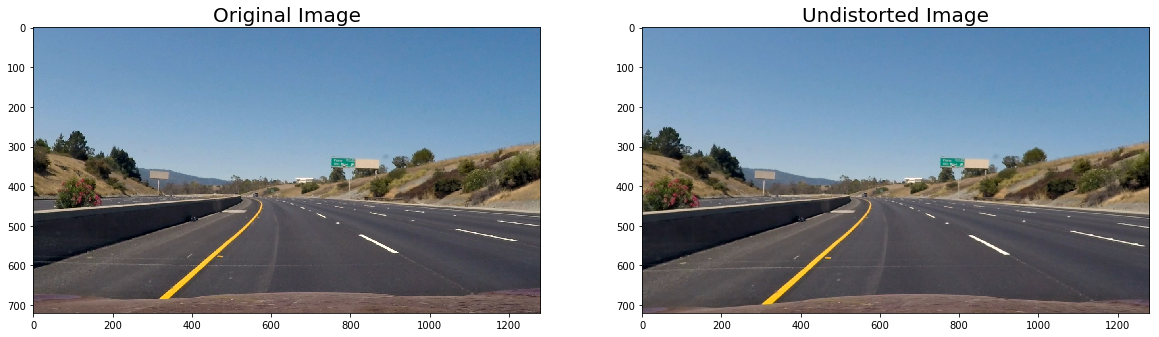

In [5]:
# show one undistorted example
img = test_imgs[4]
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

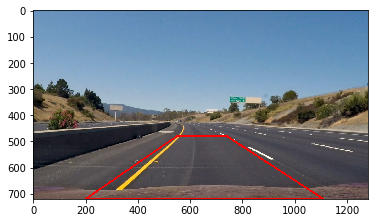

In [6]:
# find source points for warping
image = np.copy(test_imgs[4])
# source points
s_pts = np.array(((550, 480), (740, 480), (1110, 720), (200, 720)), np.float32)
# draw boundaries
cv2.polylines(image, np.int_([s_pts]), True, (255, 0, 0), thickness=5)

plt.imshow(image)
plt.show()

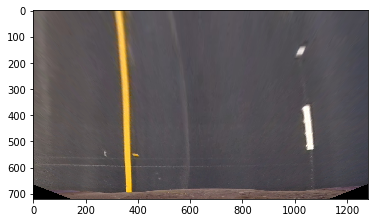

In [7]:
# find destination points and warp
d_pts = np.array(((300, 0), (1000, 0), (1000, 720), (300, 720)), np.float32)

M = cv2.getPerspectiveTransform(s_pts, d_pts)
warped_image = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

plt.imshow(warped_image)
plt.show()

In [8]:
# define helper functions
def transform_params():
    s_pts = np.array(((550, 480), (740, 480), (1110, 720), (200, 720)), np.float32)
    d_pts = np.array(((300, 0), (1000, 0), (1000, 720), (300, 720)), np.float32)
    M = cv2.getPerspectiveTransform(s_pts, d_pts)
    Minv = cv2.getPerspectiveTransform(d_pts, s_pts)
    return M, Minv

M, Minv = transform_params()

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

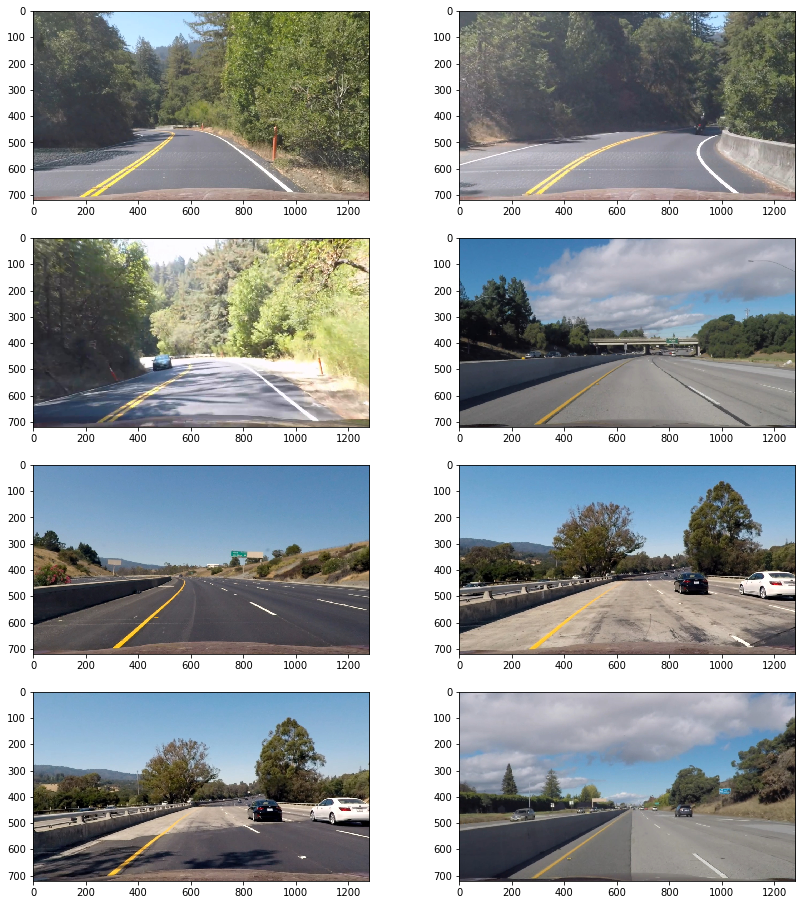

In [9]:
undistorted = []
for img in test_imgs:
    img = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted.append(img)
show_img(undistorted)

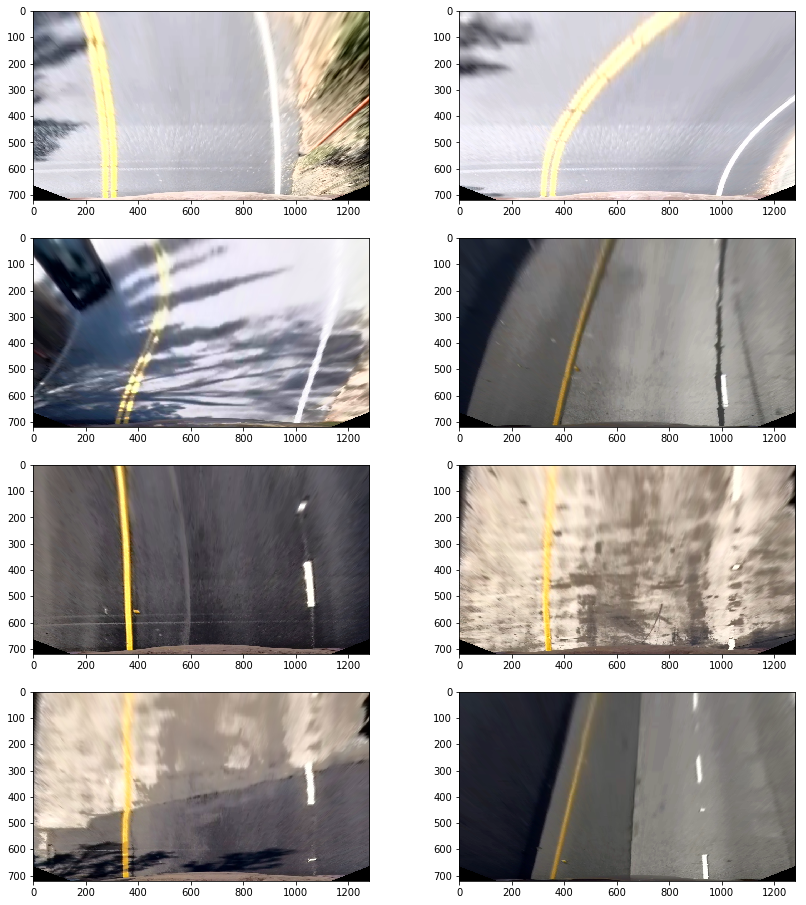

In [10]:
def warp(img, M):
    # also, perform contrast correction
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

warped = []
for img in undistorted:
    img = warp(img, M)
    warped.append(img)
show_img(warped)

In [11]:
# define functions for for color and gradient threshold
def sobelxy(img, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[scaled_sobel >= thresh] = 1
    return binary_output

def magnitude(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    mag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_mag = np.uint8(255 * mag / np.max(mag))
    binary_output = np.zeros_like(scaled_mag)
    binary_output[scaled_mag >= thresh] = 1
    return binary_output

def color_thresh(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    B = lab[:,:,2]
    B = cv2.morphologyEx(B, cv2.MORPH_TOPHAT, np.ones((25,25),np.uint8))
    thresh_b = (5, 100)
    thresh_l = (245, 255)
    color = np.zeros_like(L)
    cond1 = (L > thresh_l[0]) & (L <= thresh_l[1])
    cond2 = (B > thresh_b[0]) & (B <= thresh_b[1])
    color[cond1 | cond2] = 1
    return color

In [12]:
def apply_colorgrad(img):
    # gradient part
    sobelx = sobelxy(img, 'x', sobel_kernel=15, thresh=50)
    sobely = sobelxy(img, 'y', sobel_kernel=15, thresh=50)
    mag = magnitude(img, sobel_kernel=15, thresh=50)
    grad = np.zeros_like(sobelx)
    cond_xy = (sobelx == 1) & (sobely == 1)
    grad[cond_xy | (mag == 1)] = 1
    # color part
    color = color_thresh(img)
    # combine color and gradient
    combined = np.zeros_like(grad)
    combined[(color == 1) | (grad == 1)] = 1
    combined = cv2.erode(combined, np.ones((7,7),np.uint8), iterations=1)
    return combined

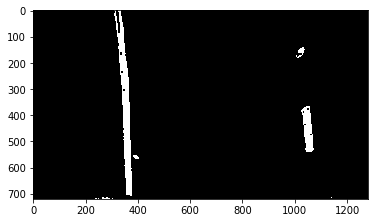

In [13]:
# apply tresholding
binary = []
for img in warped:
    combined = apply_colorgrad(img)
    binary.append(combined)
# show_img(binary, 'gray')
plt.imshow(binary[4], cmap='gray')
plt.show()

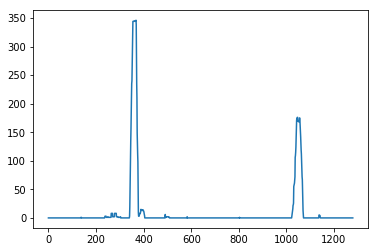

In [14]:
img = binary[4]
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

In [15]:
midpoint = histogram.shape[0] // 2
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base, rightx_base)

368 1046


In [16]:
def find_lines(img, window_height=60):
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    midpoint = histogram.shape[0] // 2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = img.shape[0] // window_height
    nonzeroy = np.array(img.nonzero()[0])
    nonzerox = np.array(img.nonzero()[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 40
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_coeffs = np.polyfit(lefty, leftx, 2)
    right_coeffs = np.polyfit(righty, rightx, 2)
    
    # draw info
    info_img = np.dstack((img, img, img)) * 255
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left, right = create_lines(img.shape, left_coeffs, right_coeffs)
    pts_left = np.array([np.transpose(np.vstack([left, ploty]))])
    pts_right = np.array([np.transpose(np.vstack([right, ploty]))])
    pts_left = np.int_([pts_left])
    pts_left = pts_left.reshape((-1,1,2))
    pts_right = np.int_([pts_right])
    pts_right = pts_right.reshape((-1,1,2))
    cv2.polylines(info_img, pts_left, True, (0,255,0), 15)
    cv2.polylines(info_img, pts_right, True, (255,0,0), 15)
    
    return left_coeffs, right_coeffs, info_img
    
def create_lines(shape, left_coeffs, right_coeffs):
    ploty = np.linspace(0, shape[0]-1, shape[0])
    left_line = left_coeffs[0]*ploty**2 + left_coeffs[1]*ploty + left_coeffs[2]
    right_line = right_coeffs[0]*ploty**2 + right_coeffs[1]*ploty + right_coeffs[2]
    return left_line, right_line

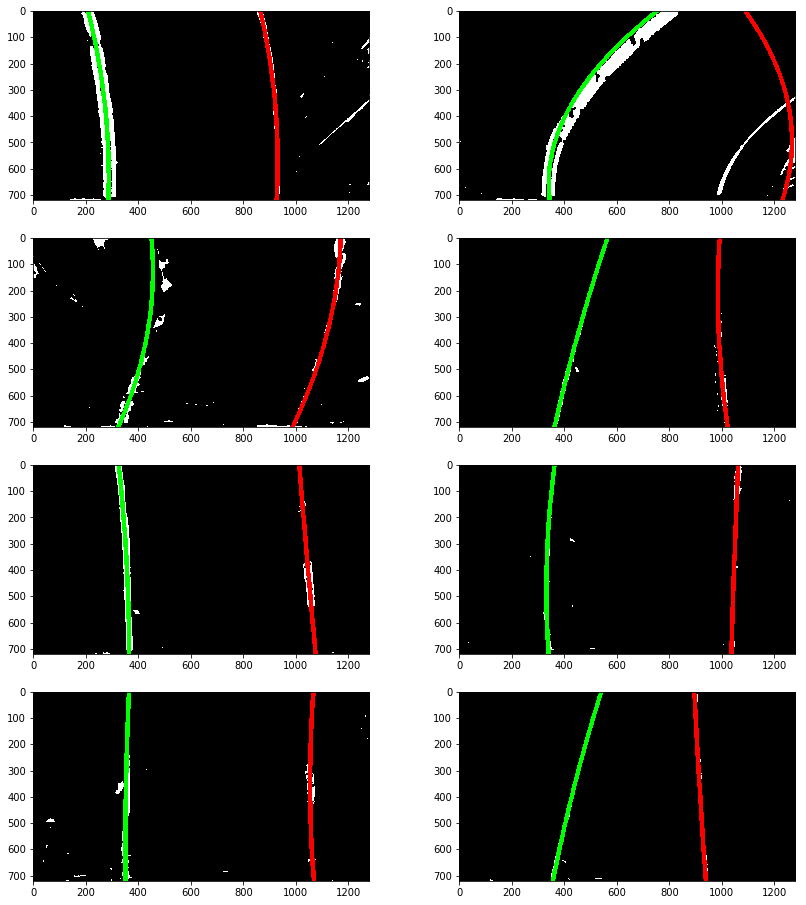

In [17]:
# find lines
left_l = []
right_l = []
left_coeffs, right_coeffs = [], []
drawn_lines = []
for img in binary:
    left_c, right_c, out = find_lines(img)
    left_line, right_line = create_lines(img.shape, left_c, right_c)
    drawn_lines.append(out)
    left_coeffs.append(left_c)
    right_coeffs.append(right_c)
    left_l.append(left_line)
    right_l.append(right_line)

show_img(drawn_lines, 'gray')

In [18]:
def draw_back(img, b, lines, warp, left, right, left_c, right_c):
    warp_zero = np.zeros_like(b).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, b.shape[0]-1, b.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    pts = np.int_([pts])
    
    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, pts, (0, 255, 0))
    p_l = np.int_([pts_left])
    p_l = p_l.reshape((-1,1,2))
    p_r = np.int_([pts_right])
    p_r = p_r.reshape((-1,1,2))
    cv2.polylines(color_warp, p_l, True, (255,0,255), 20)
    cv2.polylines(color_warp, p_r, True, (255,0,255), 20)
      
    # warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    # draw info images at the top of the frame
    info_lines = cv2.resize(lines, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_LINEAR)
    info_warp = cv2.resize(warp, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_LINEAR)
    height, width, _ = info_lines.shape
    result[:height, 2*width:3*width] = info_lines
    result[:height, 3*width:] = info_warp
    
    # text
    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = 'Radius of Curvature:'
    text2 = '650m'
    cv2.putText(result, text1, (50,40), font, 1.2, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, text2, (50,80), font, 1.2, (255,255,255), 2, cv2.LINE_AA)

    text3 = 'Vehicle is:'
    text4 = '0.12m right of center'
    
    cv2.putText(result, text3, (50,120), font, 1.2, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, text4, (50,160), font, 1.2, (255,255,255), 2, cv2.LINE_AA)
    return result

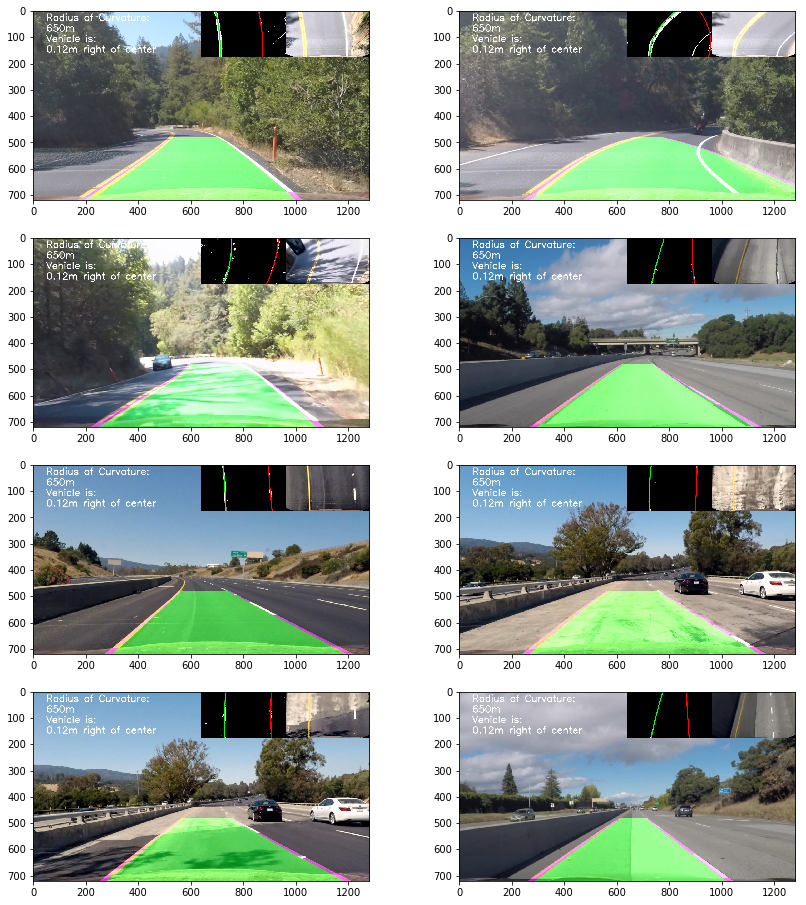

In [19]:
cols = 2
rows = (len(undistorted)+1)//cols
plt.figure(figsize=(14, 16))
for i, b, lines, warp, img in zip(np.arange(len(undistorted)), binary, drawn_lines, warped, undistorted):
    plt.subplot(rows, cols, i+1)
    img = draw_back(img, b, lines, warp, left_l[i], right_l[i], left_coeffs[i], right_coeffs[i])
    plt.imshow(img)
plt.show()